In [1]:
import numpy as np
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
def regression_nn_loss(sigma_sq, epsilon = 1e-6):
    def nn_loss(y_true, y_pred):
        return 0.5 * keras.backend.mean(keras.backend.log(sigma_sq + epsilon) + keras.backend.square(y_true - y_pred) / (sigma_sq + epsilon))

    return nn_loss

In [3]:
# generate dataset
n = 10 # number of features
k = 50 # number of samples
x = 0
np.random.seed(100)
numbers_list = np.array( random.sample(range(100), k) )
while x < n:
    numbers_list = np.vstack((numbers_list, np.array( random.sample(range(100), k) )))
    x = x + 1

dataset = numbers_list.T

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
Y = dataset[:, 0].astype("float32")
X = dataset[:, 1:].astype("float32")

In [5]:
n_tot = int( X.shape[1] )
splits = int( 2 )
n_splits = int( n_tot/splits )

In [6]:
#np.random.seed(100)
#dataset = np.random.randn(500, 11)
#X = dataset[:,0:10].astype("float32")
#Y = dataset[:,10].astype("float32")

## Network 1

In [7]:
# solution 1 -- split single neurons

input = keras.layers.Input(shape = (n_tot), name = "input")
layer1 = keras.layers.Lambda(lambda x: x[:,0:n_splits], name = "split_1")(input)# take the first n_splits neurons
layer2 = keras.layers.Lambda(lambda x: x[:,n_splits:], name = "split_2")(input) # take the other neurons
output1 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_1")(layer1)# add extra dense layer
output2 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_2")(layer2)# add extra dense layer
output = keras.layers.average([output1, output2], name = "output") # average the layers to get a single output layer

model = keras.models.Model(input, output)

In [8]:
print( model.summary() )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
split_1 (Lambda)                (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
split_2 (Lambda)                (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            6           split_1[0][0]                    
______________________________________________________________________________________________

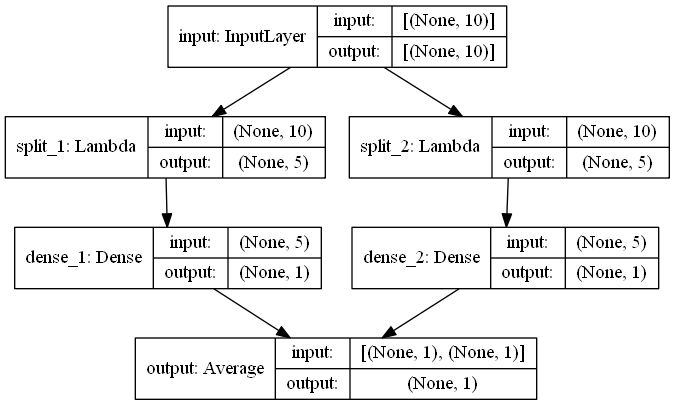

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
# fit and forecast 
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X, Y, epochs=100, verbose = 0)
forecast = model.predict(X)

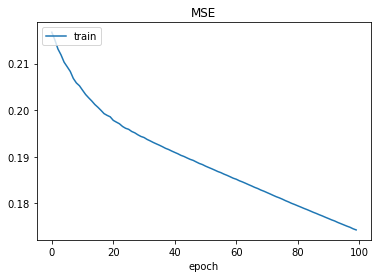

In [11]:
# plot MSE
plt.plot(history.history["loss"])
plt.title('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Network 2

In [12]:
# solution 2 -- split entire dataset

input = keras.layers.Input(shape=(n_tot), name = "input")
split = keras.layers.Lambda(lambda x: tf.split(x,num_or_size_splits = splits,axis = 1), name = "split")(input) # split dataset in half
layer1 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_1")(split[0])
layer2 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_2")(split[1])
output = keras.layers.concatenate([layer1, layer2], name = "output") # produces a different output for each subset

model = keras.models.Model(input, output)

In [13]:
print( model.summary() )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
split (Lambda)                  [(None, 5), (None, 5 0           input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            6           split[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            6           split[0][1]                      
____________________________________________________________________________________________

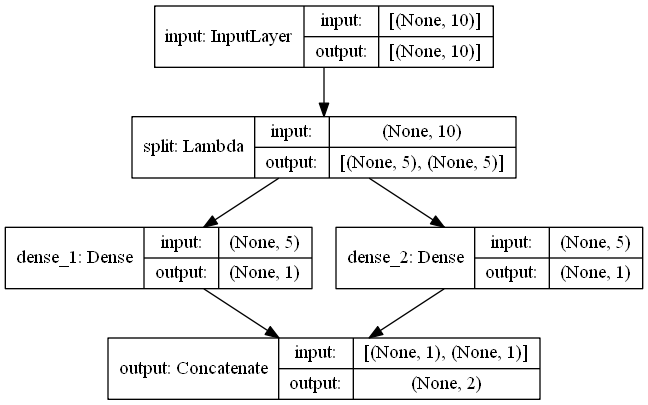

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
# fit and forecast 
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X, Y, epochs=100, verbose = 0)
forecast = model.predict(X)

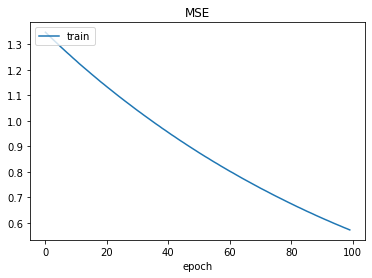

In [16]:
# plot MSE
plt.plot(history.history["loss"])
plt.title('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Network 3

In [17]:
# solution 3 -- separate inputs 
input_1 = keras.layers.Input(shape=(n_splits,), name = "input_1")
input_2 = keras.layers.Input(shape=(n_splits,), name = "input_2")
layer_1 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_1")(input_1)
layer_2 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_2")(input_2)
output = keras.layers.Add(name = "output")([layer_1, layer_2])

model = keras.models.Model(inputs=[input_1,input_2], outputs=output)

In [18]:
print( model.summary() )

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            6           input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            6           input_2[0][0]                    
____________________________________________________________________________________________

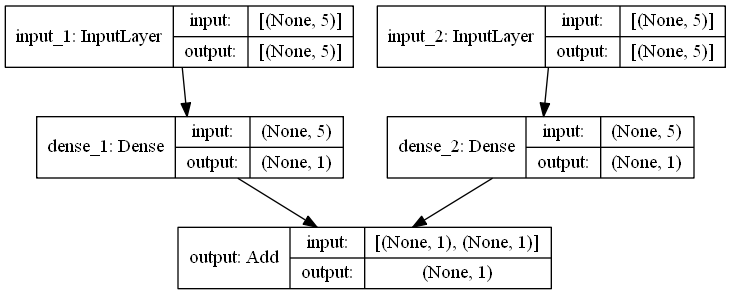

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
# fit and forecast 
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
XX = (X[:, :n_splits], X[:, n_splits:])
history = model.fit(XX, Y, epochs=100, verbose = 0)
forecast = model.predict(XX)

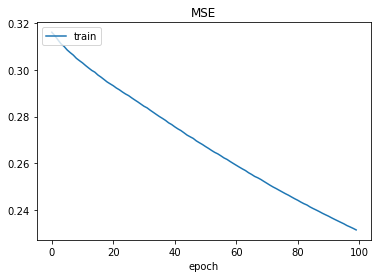

In [21]:
# plot MSE
plt.plot(history.history["loss"])
plt.title('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confidence interval for network 1

In [22]:
warnings.filterwarnings("ignore")
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [23]:
# confidence interval 
input = keras.layers.Input(shape = (n_tot), name = "input")
layer1 = keras.layers.Lambda(lambda x: x[:,0:n_splits], name = "split_1")(input)  
layer2 = keras.layers.Lambda(lambda x: x[:,n_splits:], name = "split_2")(input)   
output1 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_1")(layer1)                 
output2 = keras.layers.Dense(units = 1, activation = "linear", name = "dense_2")(layer2)                 
output = keras.layers.average([output1, output2], name = "output")           
mean = keras.layers.Dense(units = 1, activation = "linear", name = "mean")(output) # add layer for the mean
var = keras.layers.Dense(units = 1, activation = "softplus", name = "variance")(output) # add layer for the variance

train_model = keras.models.Model(input, mean)
pred_model = keras.models.Model(input, [mean, var])

In [24]:
print(pred_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
split_1 (Lambda)                (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
split_2 (Lambda)                (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            6           split_1[0][0]                    
____________________________________________________________________________________________

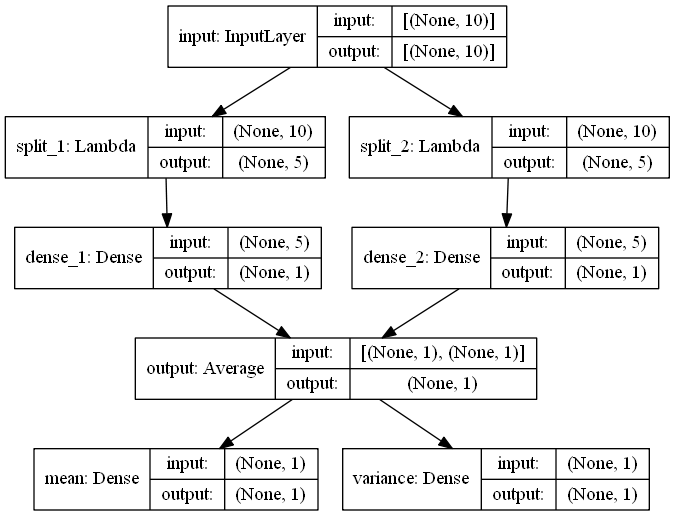

In [25]:
plot_model(pred_model, show_shapes=True, show_layer_names=True)

In [26]:
train_model.compile(loss=regression_nn_loss(var), optimizer="adam", metrics=['MeanSquaredError'])
history = train_model.fit(X, Y, epochs = 100, verbose = 0)
mean, var = pred_model.predict(X)

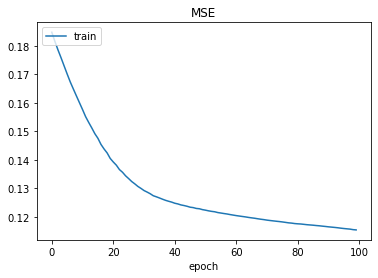

In [27]:
# plot MSE
plt.plot(history.history["MeanSquaredError"])
plt.title('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

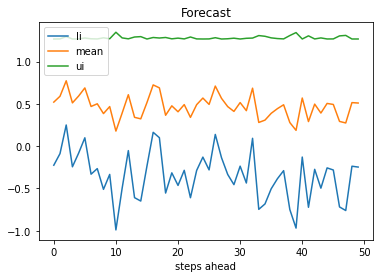

In [28]:
# plot confidence interval
li = mean - 1.96*var
ui = mean + 1.96*var
fin = np.concatenate((li, mean, ui), axis = 1)
plt.plot(fin)
plt.title('Forecast')
plt.xlabel('steps ahead')
plt.legend(["li",'mean', "ui"], loc='upper left')
plt.show()

In [29]:
# feature importance
perm = PermutationImportance(train_model, scoring = 'neg_mean_squared_error', random_state = 1).fit(X, Y)
eli5.show_weights(perm)

Weight,Feature
0.0034 ± 0.0036,x9
0.0028 ± 0.0045,x1
0.0008 ± 0.0060,x5
0.0000 ± 0.0002,x3
-0.0006 ± 0.0043,x2
-0.0011 ± 0.0097,x0
-0.0016 ± 0.0106,x7
-0.0016 ± 0.0023,x8
-0.0047 ± 0.0061,x4
-0.0129 ± 0.0109,x6
